In [20]:
import numpy as np
import torch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split

In [2]:
def split_sequences(data, n_input, n_output):
    """Expects input data to be of shape (n_series, series_len, n_features)
       Returns:
           - X of shape (n_series * (series_len - (n_input + n_output) + 1), n_input, n_features)
           - Y of shape (n_series * (series_len - (n_input + n_output) + 1), n_output, n_features)
    """
    X = []
    Y = []
    # For each time series, split into sequences of x of length n_input and y of length n_output immediately following x
    for i in range(data.shape[0]):
        # series.shape: (series_len, n_features)
        series = data[i]
        series_len = series.shape[0]
        for j in range(series_len - (n_input + n_output) + 1):
            given_wind_start = j
            given_wind_end = given_wind_start + n_input
            x = series[given_wind_start:given_wind_end, :]
            pred_wind_start = given_wind_end
            pred_wind_end = pred_wind_start + n_output
            y = series[pred_wind_start:pred_wind_end, :]
            
            X.append(x)
            Y.append(y)
    
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [ ]:
data = [[i for i in range(1, 21)], [i for i in range(2, 22)], [i for i in range(3, 23)]]
data = np.array(data)
data = data.reshape(3, 20, 1)
print(data.shape)

# Sanity check split_sequences_function
X, Y = split_sequences(data, n_input=10, n_output=1)
print(X.shape)
print(Y.shape)
print(X[0], Y[0])
print(X[9], Y[9])
print(X[10], Y[10])

X, Y = split_sequences(data, n_input=10, n_output=2)
print(X.shape)
print(Y.shape)
print(X[0], Y[0])
print(X[8], Y[8])
print(X[9], Y[9])

In [3]:
DATA_FILE = './data/processed/x_without_artifact.pt'

In [4]:
data = torch.load(DATA_FILE)

In [5]:
data = data.numpy()
print(data.shape)

(72, 500, 2)


In [6]:
rng = np.random.default_rng(seed=7)

In [7]:
idx = np.arange(72)
rng.shuffle(idx)

In [8]:
print(idx)

[28 46 12 16 40  4  1 10  6 24 65 47 36 64 26 45 69 63  0  2 55 32 39 70
 68 19 37 14 20 42 51 22 61 53 71 59 27 44  9  3 49 35 54 67 56 13 50 58
 17 18 31 62 34  5  8  7 33 57 30 15 29 38 48 23 52 25 43 66 60 21 41 11]


In [9]:
data_train = data[idx[0:50], :, :]
data_val = data[idx[50:61], :, :]
data_test = data[idx[61:72], :, :]
print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(50, 500, 2)
(11, 500, 2)
(11, 500, 2)


In [10]:
# Define split sequence parameters
n_input = 10
n_output = 10
n_features = data.shape[-1]

In [11]:
X_train, Y_train = split_sequences(data_train, n_input=n_input, n_output=n_output)
# y_train = Y_train.reshape(-1, n_output * n_features)

In [12]:
X_val, Y_val = split_sequences(data_val, n_input=n_input, n_output=n_output)
# y_val = Y_val.reshape(-1, n_output * n_features)

In [13]:
X_test, Y_test = split_sequences(data_test, n_input=n_input, n_output=n_output)
# y_test = Y_test.reshape(-1, n_output * n_features)

In [15]:
print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)

print(X_test.shape)
print(Y_test.shape)

(24050, 10, 2)
(24050, 10, 2)
(5291, 10, 2)
(5291, 10, 2)
(5291, 10, 2)
(5291, 10, 2)


In [41]:
# Define model parameters
hidden_dim = 100

In [42]:
# Define model
model = Sequential()
model.add(LSTM(hidden_dim, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_output * n_features))
model.add(Reshape((n_output, n_features)))
model.compile(optimizer='adam', loss='mse')

In [43]:
# Define model training parameters
batch_size = 32
epochs = 2

In [44]:
# Fit model
model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs)

Train on 24050 samples
Epoch 1/2
24050/24050 [==============================] - 6s 253us/sample - loss: 75.7348
Epoch 2/2
24050/24050 [==============================] - 6s 240us/sample - loss: 0.0553


In [45]:
# Evaluate model on validation data
model.evaluate(X_val, Y_val)

5291/5291 [==============================] - 1s 106us/sample - loss: 0.0334


0.03339050421528229

In [46]:
print(data_val.shape)

(11, 500, 2)


In [47]:
# Define generation parameters
to_gen_len = 500

In [48]:
# Generate full sequence
ex_i = 0
series = data_val[ex_i, 0:n_input, :]
for t in range(to_gen_len - (n_input + n_output) + 1):
    y_hat = model.predict(series[-n_input:, :][None, :, :])
    series = np.concatenate((series, y_hat[:, 0, :]), axis=0)

In [49]:
print(series)

[[ 40.07361  -70.38531 ]
 [ 40.07481  -70.38391 ]
 [ 40.07329  -70.38474 ]
 [ 40.074665 -70.38225 ]
 [ 40.076073 -70.3797  ]
 [ 40.077396 -70.3773  ]
 [ 40.07865  -70.37502 ]
 [ 40.07995  -70.372665]
 [ 40.08123  -70.370346]
 [ 40.082542 -70.36797 ]
 [ 39.793938 -70.29039 ]
 [ 39.866386 -70.26272 ]
 [ 39.858463 -70.268456]
 [ 39.83226  -70.29745 ]
 [ 39.8196   -70.29842 ]
 [ 39.817955 -70.31243 ]
 [ 39.811066 -70.3099  ]
 [ 39.80595  -70.3153  ]
 [ 39.77051  -70.30763 ]
 [ 39.74077  -70.300865]
 [ 39.73682  -70.299545]
 [ 39.729904 -70.30473 ]
 [ 39.723698 -70.31839 ]
 [ 39.724277 -70.33296 ]
 [ 39.721313 -70.343285]
 [ 39.721462 -70.35157 ]
 [ 39.716206 -70.35637 ]
 [ 39.71042  -70.36263 ]
 [ 39.706997 -70.36917 ]
 [ 39.70662  -70.37789 ]
 [ 39.706276 -70.38743 ]
 [ 39.708076 -70.39866 ]
 [ 39.71169  -70.41086 ]
 [ 39.71511  -70.42248 ]
 [ 39.717793 -70.432594]
 [ 39.719994 -70.4416  ]
 [ 39.72235  -70.45047 ]
 [ 39.725834 -70.46014 ]
 [ 39.729603 -70.47023 ]
 [ 39.73384  -70.480606]


In [50]:
print(data_val[ex_i])

[[ 40.07361  -70.38531 ]
 [ 40.07481  -70.38391 ]
 [ 40.07329  -70.38474 ]
 [ 40.074665 -70.38225 ]
 [ 40.076073 -70.3797  ]
 [ 40.077396 -70.3773  ]
 [ 40.07865  -70.37502 ]
 [ 40.07995  -70.372665]
 [ 40.08123  -70.370346]
 [ 40.082542 -70.36797 ]
 [ 40.083874 -70.365555]
 [ 40.085133 -70.36327 ]
 [ 40.086346 -70.36107 ]
 [ 40.08758  -70.35883 ]
 [ 40.088802 -70.35662 ]
 [ 40.08989  -70.354645]
 [ 40.091    -70.35264 ]
 [ 40.092155 -70.35054 ]
 [ 40.089073 -70.349655]
 [ 40.0895   -70.34679 ]
 [ 40.089947 -70.34388 ]
 [ 40.09034  -70.34133 ]
 [ 40.09073  -70.338776]
 [ 40.091114 -70.33626 ]
 [ 40.091496 -70.33376 ]
 [ 40.091892 -70.33118 ]
 [ 40.092293 -70.32857 ]
 [ 40.092686 -70.32599 ]
 [ 40.09306  -70.32354 ]
 [ 40.09346  -70.320946]
 [ 40.093864 -70.31828 ]
 [ 40.09422  -70.31597 ]
 [ 40.094563 -70.313736]
 [ 40.094917 -70.31141 ]
 [ 40.095284 -70.30904 ]
 [ 40.095654 -70.3066  ]
 [ 40.096016 -70.304245]
 [ 40.09637  -70.30193 ]
 [ 40.093536 -70.29795 ]
 [ 40.09325  -70.29513 ]


In [51]:
import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
import numpy as np
from matplotlib import cm
from matplotlib import colors
from constants import *

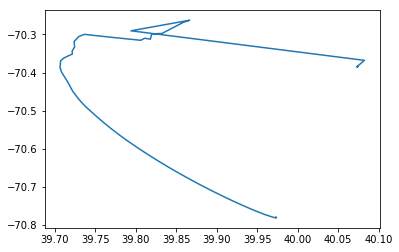

In [52]:
plt.plot(series[:, 0], series[:, 1])

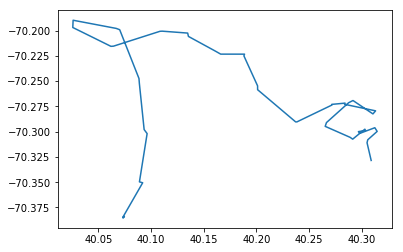

In [53]:
plt.plot(data_val[ex_i, :, 0], data_val[ex_i, :, 1])

In [110]:
# Generate full sequence
ex_i = 5
series = data_val[ex_i, 0:n_input, :]
for t in range(to_gen_len - (n_input + n_output) + 1):
    y_hat = model.predict(series[-n_input:, :][None, :, :])
    series = np.concatenate((series, y_hat[:, 0, :]), axis=0)

In [111]:
print(series)

[[ 40.040333 -70.6972  ]
 [ 40.046185 -70.6972  ]
 [ 40.048237 -70.697914]
 [ 40.049282 -70.698364]
 [ 40.050034 -70.7048  ]
 [ 40.0618   -70.71644 ]
 [ 40.07078  -70.724594]
 [ 40.07082  -70.73325 ]
 [ 40.077454 -70.74449 ]
 [ 40.086582 -70.751816]
 [ 39.93983  -70.66826 ]
 [ 39.984554 -70.65347 ]
 [ 39.982784 -70.6556  ]
 [ 39.970722 -70.68088 ]
 [ 39.970036 -70.68516 ]
 [ 39.970425 -70.687904]
 [ 39.96601  -70.68311 ]
 [ 39.969296 -70.68459 ]
 [ 39.954674 -70.68089 ]
 [ 39.939487 -70.67382 ]
 [ 39.931454 -70.66325 ]
 [ 39.9306   -70.66281 ]
 [ 39.928413 -70.6687  ]
 [ 39.930313 -70.67739 ]
 [ 39.927937 -70.67999 ]
 [ 39.926865 -70.67973 ]
 [ 39.92436  -70.67804 ]
 [ 39.921482 -70.67828 ]
 [ 39.918316 -70.678795]
 [ 39.916122 -70.67941 ]
 [ 39.914173 -70.679985]
 [ 39.914505 -70.68259 ]
 [ 39.915485 -70.6864  ]
 [ 39.916107 -70.689995]
 [ 39.91578  -70.69185 ]
 [ 39.915287 -70.692764]
 [ 39.91489  -70.69376 ]
 [ 39.915005 -70.69567 ]
 [ 39.915115 -70.697914]
 [ 39.9154   -70.70016 ]


In [112]:
print(data_val[ex_i])

[[ 40.040333 -70.6972  ]
 [ 40.046185 -70.6972  ]
 [ 40.048237 -70.697914]
 [ 40.049282 -70.698364]
 [ 40.050034 -70.7048  ]
 [ 40.0618   -70.71644 ]
 [ 40.07078  -70.724594]
 [ 40.07082  -70.73325 ]
 [ 40.077454 -70.74449 ]
 [ 40.086582 -70.751816]
 [ 40.093983 -70.7506  ]
 [ 40.0967   -70.741585]
 [ 40.099705 -70.73329 ]
 [ 40.10259  -70.73802 ]
 [ 40.11936  -70.744194]
 [ 40.138157 -70.74609 ]
 [ 40.146183 -70.748764]
 [ 40.147488 -70.75258 ]
 [ 40.14813  -70.76427 ]
 [ 40.156693 -70.77881 ]
 [ 40.172096 -70.78828 ]
 [ 40.189888 -70.78568 ]
 [ 40.202694 -70.78723 ]
 [ 40.213192 -70.792534]
 [ 40.225895 -70.79824 ]
 [ 40.241505 -70.7984  ]
 [ 40.254795 -70.79711 ]
 [ 40.262516 -70.799225]
 [ 40.26227  -70.805565]
 [ 40.267544 -70.8184  ]
 [ 40.282467 -70.82604 ]
 [ 40.299583 -70.8234  ]
 [ 40.313587 -70.82042 ]
 [ 40.319717 -70.82267 ]
 [ 40.325188 -70.83082 ]
 [ 40.336628 -70.83562 ]
 [ 40.354237 -70.83122 ]
 [ 40.3533   -70.82085 ]
 [ 40.331284 -70.809   ]
 [ 40.307518 -70.80504 ]


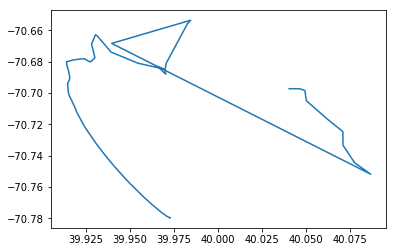

In [113]:
plt.plot(series[:, 0], series[:, 1])

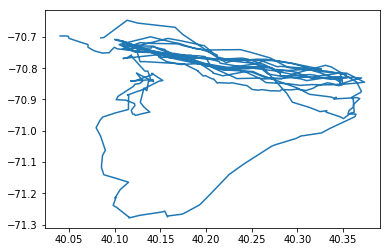

In [114]:
plt.plot(data_val[ex_i, :, 0], data_val[ex_i, :, 1])